# MOVIE RECOMMENDATION SYSTEM

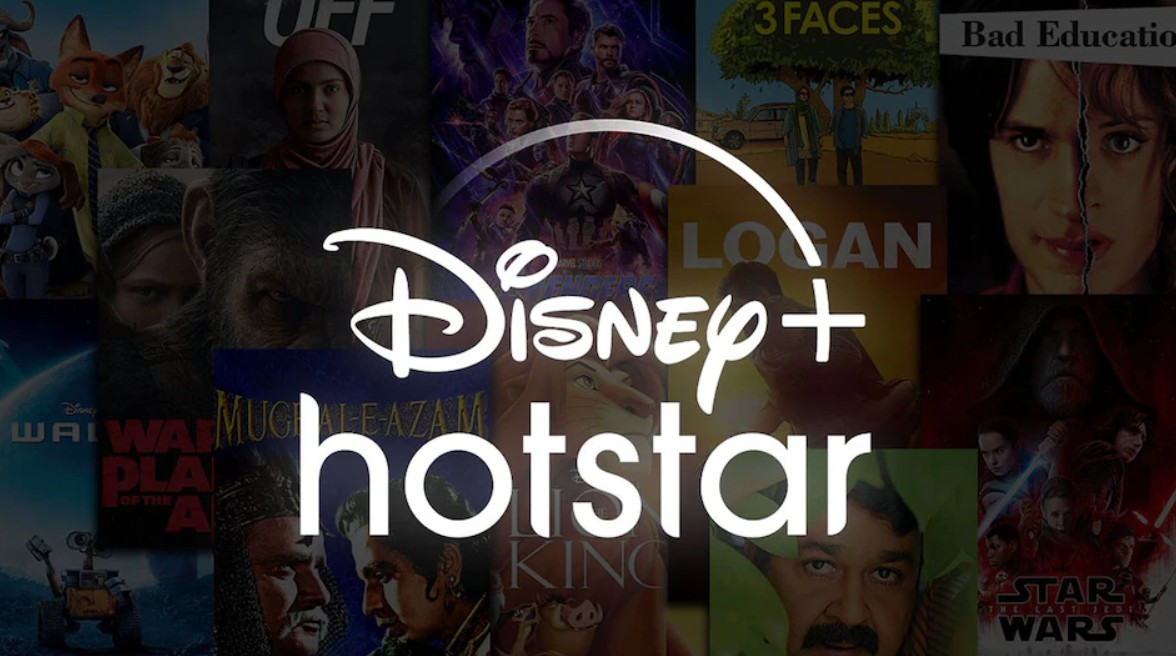

In this notebook,I have made a basic movie recommendation system using item based Collaborative Filtering.

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.
It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

**Item-based collaborative filtering**

Item-item collaborative filtering, or item-based, or item-to-item, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items. Item-item collaborative filtering was invented and used by Amazon.com in 1998.It was first published in an academic conference in 2001.

Earlier collaborative filtering systems based on rating similarity between users (known as user-user collaborative filtering) had several problems:

systems performed poorly when they had many items but comparatively few ratings
computing similarities between all pairs of users was expensive
user profiles changed quickly and the entire system model had to be recomputed
Item-item models resolve these problems in systems that have more users than items. Item-item models use rating distributions per item, not per user. With more users than items, each item tends to have more ratings than each user, so an item's average rating usually doesn't change quickly. This leads to more stable rating distributions in the model, so the model doesn't have to be rebuilt as often. When users consume and then rate an item, that item's similar items are picked from the existing system model and added to the user's recommendations.

**Method**

First, the system executes a model-building stage by finding the similarity between all pairs of items. This similarity function can take many forms, such as correlation between ratings or cosine of those rating vectors. As in user-user systems, similarity functions can use normalized ratings (correcting, for instance, for each user's average rating).

Second, the system executes a recommendation stage. It uses the most similar items to a user's already-rated items to generate a list of recommendations. Usually this calculation is a weighted sum or linear regression. This form of recommendation is analogous to "people who rate item X highly, like you, also tend to rate item Y highly, and you haven't rated item Y yet, so you should try it".**

**So let's get started**

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

**Importing the dataset**

In [2]:
movie=pd.read_csv('../input/movielens-20m-dataset/movie.csv')
rating=pd.read_csv('../input/movielens-20m-dataset/rating.csv')
tag=pd.read_csv('../input/movielens-20m-dataset/tag.csv')

let's have a look at our dataset

In [3]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


First clean our dataset a bit by clearing year from title column and generating year column.

In [4]:
movie['year'] = movie.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movie['year'] = movie.year.str.extract('(\d\d\d\d)',expand=False)

In [5]:
#Removing the years from the 'title' column
movie['title'] = movie.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
movie['title'] = movie['title'].str.strip()
movie.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [6]:
rating.groupby('movieId').rating.mean()
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Now join the two data sets as we require user ID , movie rating, and name of all the movies for our model.

In [7]:
df=movie.join(rating,lsuffix='N', rsuffix='K')
df

,movieIdN,title,genres,year,userId,movieIdK,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,2,3.5,2005-04-02 23:53:47
1,2,Jumanji,Adventure|Children|Fantasy,1995,1,29,3.5,2005-04-02 23:31:16
2,3,Grumpier Old Men,Comedy|Romance,1995,1,32,3.5,2005-04-02 23:33:39
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,1,47,3.5,2005-04-02 23:32:07
4,5,Father of the Bride Part II,Comedy,1995,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben,Comedy,2007,211,527,5.0,2006-10-08 18:35:17
27274,131256,"Feuer, Eis & Dosenbier",Comedy,2002,211,589,3.5,2006-10-08 18:37:28
27275,131258,The Pirates,Adventure,2014,211,593,4.0,2006-10-08 18:38:01
27276,131260,Rentun Ruusu,(no genres listed),2001,211,594,4.5,2006-10-08 18:31:34


Let's remove unnessesary columns.

In [8]:
df=df.drop(['movieIdK','genres','year','timestamp'],axis=1)

We have to make a matrix with these columns for our model.

In [9]:
# There will be lot of nan value in our new dataframe as it is highly unlikely that that ours users have seen almost all movies.
movie_users=df.pivot(index='movieIdN', columns='userId',values='rating').fillna(0)
matrix_movies_users=csr_matrix(movie_users.values)
print(matrix_movies_users)

  (0, 0)	3.5
  (1, 0)	3.5
  (2, 0)	3.5
  (3, 0)	3.5
  (4, 0)	3.5
  (5, 0)	3.5
  (6, 0)	4.0
  (7, 0)	4.0
  (8, 0)	4.0
  (9, 0)	4.0
  (10, 0)	4.0
  (11, 0)	4.0
  (12, 0)	4.0
  (13, 0)	3.5
  (14, 0)	3.5
  (15, 0)	4.0
  (16, 0)	3.5
  (17, 0)	3.5
  (18, 0)	3.0
  (19, 0)	3.5
  (20, 0)	3.5
  (21, 0)	3.5
  (22, 0)	4.0
  (23, 0)	4.0
  (24, 0)	3.5
  :	:
  (27253, 209)	3.0
  (27254, 209)	4.0
  (27255, 209)	5.0
  (27256, 209)	4.0
  (27257, 209)	4.0
  (27258, 209)	4.0
  (27259, 209)	2.0
  (27260, 210)	3.0
  (27261, 210)	3.0
  (27262, 210)	3.0
  (27263, 210)	4.0
  (27264, 210)	4.0
  (27265, 210)	5.0
  (27266, 210)	3.0
  (27267, 210)	4.0
  (27268, 210)	5.0
  (27269, 210)	4.0
  (27270, 210)	4.0
  (27271, 210)	5.0
  (27272, 210)	3.0
  (27273, 210)	5.0
  (27274, 210)	3.5
  (27275, 210)	4.0
  (27276, 210)	4.5
  (27277, 210)	4.0


We gonna use NearestNeighbors for computing similarities between the ratings rated by other users on same movie.
There are different metric in knn like Euclidean Distance,Manhattan Distance,Minkowski Distance,Cosine Similarity.In this we will use cosine similarity as our metric.

In [10]:
knn= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)

**Fitting the model**

In [11]:
knn.fit(matrix_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

Now let's make our recommendation function.In this I have used a function from library named as fuzzywuzzy ,it solves the problem of finding the movies with mis-spells and regardless of its letter in lower case or upper case.

In [12]:
def recommender(movie_name, data,model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, df['title'])[2]
    print('Movie Selected:-',df['title'][idx], 'Index: ',idx)
    print('Searching for recommendations.....')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(df['title'][i].where(i!=idx))
    
recommender('jumanji', matrix_movies_users, knn,5)

Movie Selected:- Jumanji Index:  1
Searching for recommendations.....
117                   Steal Big, Steal Little
115            Young Poisoner's Handbook, The
119                  Boys of St. Vincent, The
118                              Race the Sun
121    Chungking Express (Chung Hing sam lam)
Name: title, dtype: object


# **Results**

Item-item collaborative filtering had less error than user-user collaborative filtering. In addition, its less-dynamic model was computed less often and stored in a smaller matrix, so item-item system performance was better than user-user systems.**

# **When Else Can Collaborative Filtering Be Used?**

Collaborative filtering works around the interactions that users have with items. These interactions can help find patterns that the data about the items or users itself can’t. Here are some points that can help you decide if collaborative filtering can be used:

-Collaborative filtering doesn’t require features about the items or users to be known. It is suited for a set of different types of items, for example, a supermarket’s inventory where items of various categories can be added. In a set of similar items such as that of a bookstore, though, known features like writers and genres can be useful and might benefit from content-based or hybrid approaches.

-Collaborative filtering can help recommenders to not overspecialize in a user’s profile and recommend items that are completely different from what they have seen before. If you want your recommender to not suggest a pair of sneakers to someone who just bought another similar pair of sneakers, then try to add collaborative filtering to your recommender spell.

Although collaborative Filtering is very commonly used in recommenders, some of the challenges that are faced while using it are the following:

-Collaborative filtering can lead to some problems like cold start for new items that are added to the list. Until someone rates them, they don’t get recommended.

-Data sparsity can affect the quality of user-based recommenders and also add to the cold start problem mentioned above.

-Scaling can be a challenge for growing datasets as the complexity can become too large. Item-based recommenders are faster than user-based when the dataset is large.

-With a straightforward implementation, you might observe that the recommendations tend to be already popular, and the items from the long tail section might get ignored.

With every type of recommender algorithm having its own list of pros and cons, it’s usually a hybrid recommender that comes to the rescue. The benefits of multiple algorithms working together or in a pipeline can help you set up more accurate recommenders. In fact, the solution of the winner of the Netflix prize was also a complex mix of multiple algorithms.